<a href="https://colab.research.google.com/github/k1nosabiroff/garbage-classifier/blob/main/garbage%20ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
#импортируем библиотеки PyTorch
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.dataloader import DataLoader

In [ ]:
!pip  install kaggle

In [ ]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#загружаем датасет
!kaggle datasets download asdasdasasdas/garbage-classification

 79% 65.0M/82.0M [00:00<00:00, 68.3MB/s]
100% 82.0M/82.0M [00:00<00:00, 105MB/s] 


In [ ]:
#распаковываем zip-файл
!unzip garbage-classification.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: Garbage classification/Garbage classific

In [ ]:
#указываем апуть датасета и находим категории
data_dir = 'garbage classification/Garbage classification'
classes = os.listdir(data_dir)
print(classes)

['metal', 'plastic', 'paper', 'cardboard', 'trash', 'glass']


In [ ]:
#загружаем модуль split-folders для разделения датасета
!pip  install split-folders

In [ ]:
#импортируем splitfolders
import splitfolders

In [ ]:
#делим датасет в соотношении 75% 15% 15%
input_folder = data_dir
splitfolders.ratio(input_folder, 'dataset_splited', ratio = (0.7, 0.15, 0.15), seed = 2, group_prefix = None)

Copying files: 2527 files [00:00, 5549.85 files/s]


In [ ]:
#указываем пути обучения, выборки и теста
train_ds = datasets.ImageFolder('dataset_splited/train', transform=transforms.ToTensor())
val_ds = datasets.ImageFolder('dataset_splited/val', transform=transforms.ToTensor())
test_ds = datasets.ImageFolder('dataset_splited/test', transform=transforms.ToTensor())

In [ ]:
#с помощью DataLoader указываем пути 
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

In [ ]:
# батч картинок и батч ответов к картинкам
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [ ]:
images.shape, labels.shape

(torch.Size([64, 3, 384, 512]), torch.Size([64]))

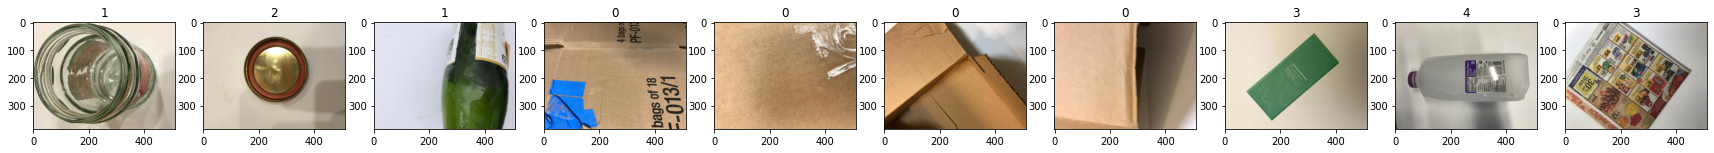

In [ ]:
#выводим изображения для примера при помощи NumPy
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = torch.nn.Flatten()
        self.fc1 = nn.Linear(512*384*3, 256) #fully-connected полносвязный
        #self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 6)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc2(x)
        return x

In [ ]:
#Обучение сети
def train(model, n_epoch=6):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    val_accuracies = []
    val_losses = []
    
    # обучаем сеть
    for epoch in tqdm_notebook(range(n_epoch)):
        train_dataiter = iter(train_loader)
        running_loss = 0.0

        model.train(True)
        for i, batch in enumerate(tqdm_notebook(train_dataiter)):
            X_batch, y_batch = batch # так получаем текущий батч
            
            logits = model(X_batch) # forward pass (получение ответов на батч картинок)
            loss = loss_fn(logits, y_batch) # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса
            # выведем текущий loss
            running_loss += loss.item()

            # выведем лосс каждые 50 батчей
            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 49))
                train_losses.append(running_loss / 49)
                running_loss = 0.0

        # evaluate on val
        model.train(False)
        val_dataiter = iter(val_loader)


        val_loss_per_epoch = 0
        val_accuracy_per_epoch = 0
        for i, batch in enumerate(tqdm_notebook(val_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            with torch.no_grad():
                logits = model(X_batch)
                y_pred = torch.argmax(logits, dim=1)
                val_accuracy_per_epoch += np.mean(y_pred.numpy() == y_batch.numpy())

                val_loss_per_epoch += loss_fn(logits, y_batch)

        val_accuracies.append(val_accuracy_per_epoch / (i + 1))
        val_losses.append(val_loss_per_epoch / (i + 1))

    print('Обучение закончено')
    return model, train_losses, val_losses, val_accuracies

In [ ]:
from tqdm import tqdm_notebook
net = SimpleNet()
#обучаем  сеть, передав переменную
net, train_losses, val_losses, val_accuracies = train(net, n_epoch=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Обучение закончено


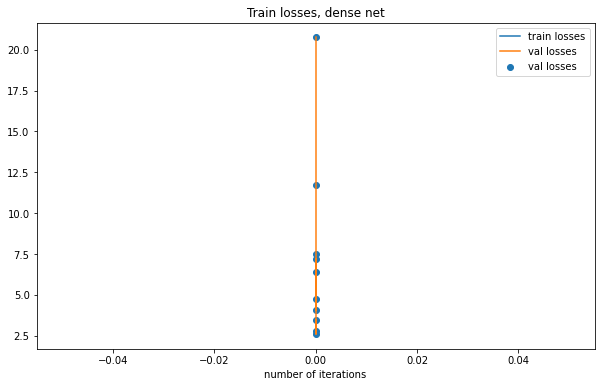

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Train losses, dense net')
plt.plot(np.arange(len(train_losses)), train_losses, label='train losses')
plt.plot(np.arange(1, len(val_losses) + 1) * (len(train_losses) // len(val_losses)), 
         val_losses, label='val losses')
plt.scatter(np.arange(1, len(val_losses) + 1) * (len(train_losses) // len(val_losses)), 
         val_losses, label='val losses')
plt.xlabel('number of iterations')
plt.legend()
plt.show()

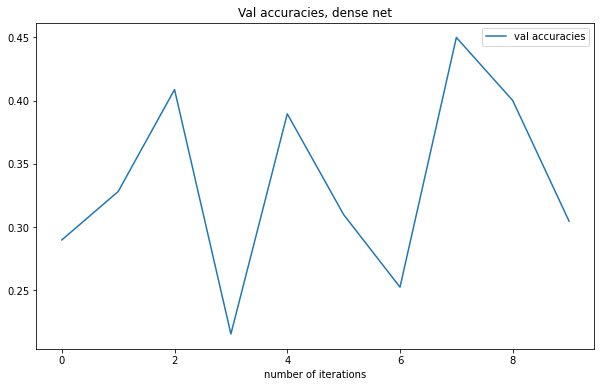

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Val accuracies, dense net')
plt.plot(np.arange(len(val_accuracies)), val_accuracies, label='val accuracies')
plt.xlabel('number of iterations')
plt.legend()
plt.show()

In [ ]:
def evaluate(model, dataloader, name='test'):
    accuracy = 0.

    dataiter = iter(dataloader)
    for i, batch in enumerate(tqdm_notebook(dataiter)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        with torch.no_grad():
            logits = model(X_batch)
            y_pred = torch.argmax(logits, dim=1)
            accuracy += np.mean(y_pred.numpy() == y_batch.numpy())
    print(f'{name} accuracy is {accuracy / (i + 1)}')
    return accuracy / (i + 1)

In [ ]:
#загружаем картинку из интернета для тестирования сети
!wget 'https://lk.kolba.ru/upload/0a0c7d6fd8.jpg' -O 'butylka.jpg'

--2021-10-29 06:09:31--  https://lk.kolba.ru/upload/0a0c7d6fd8.jpg
Resolving lk.kolba.ru (lk.kolba.ru)... 5.101.153.237
Connecting to lk.kolba.ru (lk.kolba.ru)|5.101.153.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31984 (31K) [image/jpeg]
Saving to: ‘butylka.jpg’

butylka.jpg         100%[===================>]  31.23K  --.-KB/s    in 0s      

2021-10-29 06:09:32 (261 MB/s) - ‘butylka.jpg’ saved [31984/31984]



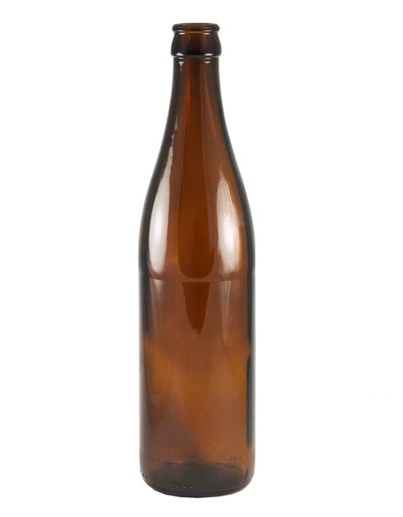

In [ ]:
from PIL import Image

image = Image.open('butylka.jpg')
image

In [ ]:
#применяем преобразования ,объединяем все с помощью transforms.Compose 
resnet_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
images_transformed = resnet_transforms(image)
print(images_transformed.shape)

torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


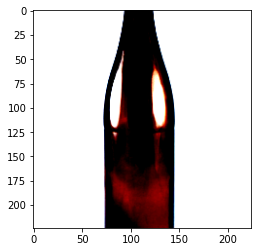

In [ ]:
plt.imshow(images_transformed.permute(1,2,0).data.cpu().numpy())

In [ ]:
#сохраняем
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')  
device

device(type='cuda', index=0)

In [ ]:
#выводим модель обученной сети
from torchvision import datasets, models, transforms
model = models.resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model_output = model(images_transformed.reshape((1, 3, 224, 224)))
model_output

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-5.9771e-01,  6.7446e-01, -9.7884e-02, -1.9977e+00,  2.0597e+00,
         -7.5620e-01, -2.4394e+00, -1.2534e+00, -2.8133e+00, -3.5544e+00,
          1.0541e+00, -5.6335e-01, -4.7689e-01, -1.4033e+00, -2.0465e+00,
          3.4643e+00,  2.7594e+00,  8.2027e-01, -2.0874e+00, -9.7083e-01,
         -1.7094e+00,  1.3488e+00, -1.6476e+00, -2.7242e+00, -3.4706e+00,
         -1.0280e+00,  1.2788e-01, -4.7184e-01, -4.1984e-01, -3.3396e+00,
         -2.9958e+00, -1.7996e+00, -2.5883e+00, -2.7125e+00, -3.4611e+00,
         -1.4893e+00, -1.5947e+00, -2.4800e+00, -1.4094e+00, -4.3129e+00,
         -7.2621e-01, -2.2800e+00, -2.6822e+00, -2.0248e+00, -2.6559e+00,
         -3.7306e+00, -2.3363e+00, -4.5244e+00, -4.7124e+00, -4.6140e+00,
         -3.5353e+00,  2.4811e-01,  8.8843e-01, -1.7971e+00, -2.0084e+00,
         -3.9248e+00, -3.5583e+00, -1.4926e+00, -3.1872e+00, -6.4964e-01,
         -1.4664e+00, -3.3335e+00, -1.9221e+00, -1.4814e+00, -3.4667e+00,
         -8.9057e-01, -7.8373e-01, -5.

In [ ]:
name = np.argmax(model_output.data.cpu().numpy())
name

440

In [ ]:
f = open('/content/one-indexed-files.txt')
all_lines = f.readlines()
print(all_lines[name-1])

glass440.jpg 1



In [ ]:
test_dataiter = iter(test_loader)
evaluate(net, test_dataiter, 'test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/6 [00:00<?, ?it/s]

test accuracy is 0.2994791666666667


0.2994791666666667

In [ ]:
train_dataiter = iter(train_loader)
evaluate(net, train_dataiter, 'train')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/28 [00:00<?, ?it/s]

train accuracy is 0.35464638157894735


0.35464638157894735

In [ ]:
torch.save(net, 'garbage classification.pt')